# Develop, evaluate, and score a forecasting model for electricity generation

In [1]:
"""
 Introduction

In this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.

Forecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.

The main steps in this notebook are:

1. Load the data
2. Understand and process the data using exploratory data analysis
3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature
4. Save the final machine learning model and make predictions
5. Demonstrate the model performance via visualizations in Power BI

Thesis

What percentage of fuel generation will come from Natural Gas in the coming months?

"""

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 3, Finished, Available)

"\n Introduction\n\nIn this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.\n\nForecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.\n\nThe main steps in this notebook are:\n\n1. Load the data\n2. Understand and process the data using exploratory data analysis\n3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature\n4. Save the final machine learning model and make pre

## Libraries and Variables

In [2]:
# Importing required libraries
import warnings
import itertools
# Record the notebook running time
import time
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
# Set up MLflow for experiment tracking
import mlflow
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
# Import required libraries for model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from pyspark.sql.functions import col, to_date
import os, requests
import statsmodels.api as sm
"""
`Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models
It also allows you to conduct statistical tests and statistical data exploration.
"""

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 4, Finished, Available)

'\n`Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models\nIt also allows you to conduct statistical tests and statistical data exploration.\n'

In [3]:
"""
Define Variables
"""

IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

IS_SAMPLE = False  # if TRUE, use only rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/salesforecast"  # folder with data files
DATA_FILE = "Superstore.xlsx"  # data file name

EXPERIMENT_NAME = "aielectric-forecast"  # MLflow experiment name

ts = time.time()

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 5, Finished, Available)

In [4]:
"""
ML Flow: Machine Learning

Autologging in Microsoft Fabric extends the MLflow autologging capabilities by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).
"""

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 6, Finished, Available)

## Step 1: Dataset

In [5]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Type.FuelClass Fuel_class
,Ops.OperatingDate Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM EIA_Lake.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_plant Ops on Fact.PlantKey = Ops.PlantKey  
GROUP BY 
Type.FuelClass 
,Ops.OperatingDate 
"""
)


df = df.withColumnRenamed("Fuel_Class", "Fuel class")
df = df.withColumnRenamed("Operating_Date", "Operating date")
df = df.withColumnRenamed("Electricity_Generated", "Electricity generated")

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 7, Finished, Available)

In [6]:
"""
Conversions
"""
df = df.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
df = df.toPandas()

"""
How to specify or convert the data types post-conversion in the Pandas DataFrame
"""

# Assuming df is your Pandas DataFrame
df['Fuel class'] = df['Fuel class'].astype(str)
# Assuming df is your Pandas DataFrame
df['Operating date'] = pd.to_datetime(df['Operating date'])
# Convert the 'Electricity generated' column to int
df['Electricity generated'] = df['Electricity generated'].astype(int)

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 8, Finished, Available)

In [7]:
"""
Step 2: Exploratory Data Analysis

Note that in this notebook, the primary focus will be on forecasting the sales for the `fossil fuels` category. 
This choice is made to speed up the computation and facilitate the demonstration of the model's performance. 
However, it is important to realize that this techniques used in this notebook are adaptable and can be extended 
to predict the sales of various other product categories.
Examples include:
- Forecast sales for a specific category of customers
- Forecast sales for a specific product category and customer combination
- Forecast overall sales for a specific product category
"""

# Filtering
df = df.loc[df['Fuel class'] == 'Fossil Fuels']
fuel = df[df['Operating date'].dt.strftime('%Y-%m-%d') >= "2000-01-01"]

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 9, Finished, Available)

In [8]:
"""
The dataset is structured on a daily basis
The goal is to develop a model to forecast the sales on a monthly basis, you need to resample on the column `Order Date`.

1. group the `Furniture` category by `Order Date` and then 
2. calculate the sum of the `Sales` column for each group in order to determine the total sales for each unique `Order Date`. 
3. resample the `Sales` column using the `MS` frequency to aggregate the data by month and then you calculate the mean sales value for each month.
"""

# Data preprocessing
fuel = fuel.sort_values('Operating date')
fuel.isnull().sum()
fuel = fuel.groupby('Operating date')['Electricity generated'].sum().reset_index()
fuel = fuel.set_index('Operating date')
# fuel.index
y = fuel['Electricity generated'].resample('MS').mean()
y = y.fillna(0) # Fill NaN values with zero
y = y.astype('int64')
y = y.reset_index()
y['Operating date'] = pd.to_datetime(y['Operating date'])
# y['Operating date'] = [i+pd.DateOffset(months=67) for i in y['Operating date']]
"""
This kind of operation might be done for various reasons. One common scenario is when you want to simulate or project data into the future. By adding 67 months to the 'Operating date' values, you are essentially shifting the timeline forward by approximately 5 and a half years (assuming each month is roughly 30 days).
For example, if the original 'Operating date' values were in the past (e.g., historical dates), adding 67 months might be used to project or simulate how the data would look like 5.5 years into the future. This kind of manipulation is often seen in financial or economic analyses where projecting future trends is essential.
"""
display(y)
y = y.set_index(['Operating date'])
maximim_date = y.reset_index()['Operating date'].max()

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 10, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7beaf672-80df-4452-b468-047da15e461d)

## Step 2: Statistical Analysis

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 11, Finished, Available)

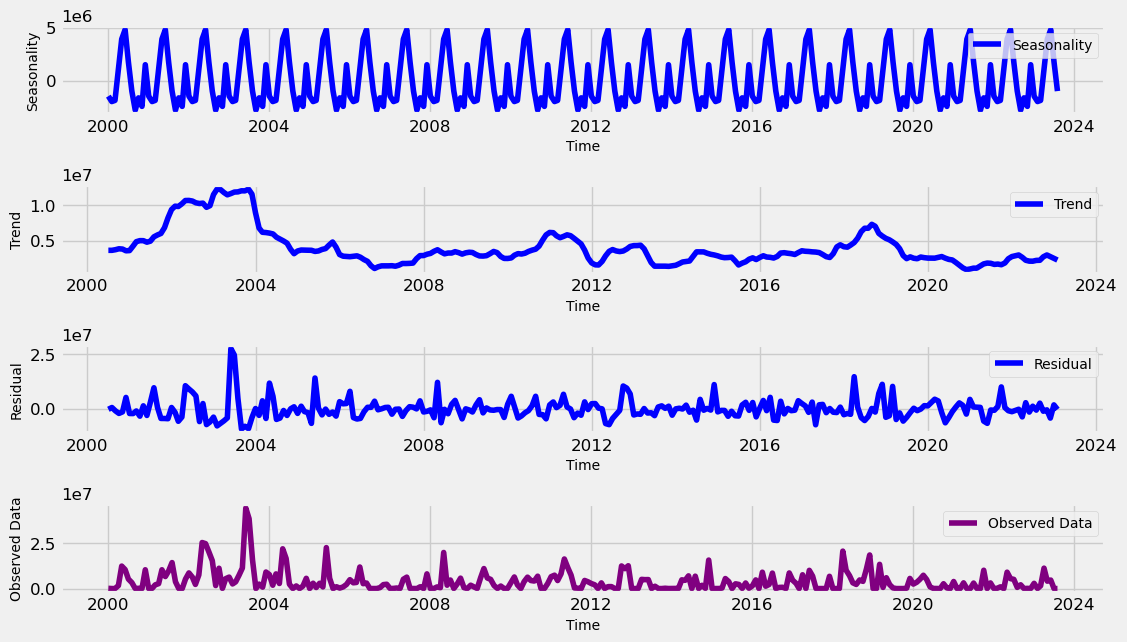

'\nDoing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.\nUnderstanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.\n'

In [9]:
"""
Statistical analysis

A time series tracks four data elements at set intervals in order to determine the variation of those four elements in the time series pattern. These elements include:

- **Level:** Refers to the fundamental component that represents the average value for a specific time period.

- **Trend:** Describes whether the time series is decreasing, constant, or increasing over time.

- **Seasonality:** Describes the periodic signal in the time series and looks for cyclic occurrences that affect the time series' increasing or decreasing patterns.

- **Noise/Residual:** Refers to the random fluctuations and variability in the time series data that cannot be explained by the model.

In the following, you will observe the above four components for your dataset after the pre-processing.
"""

# Decompose the time series into its components using statsmodels
result = sm.tsa.seasonal_decompose(y, model='additive')

# Labels and corresponding data for plotting
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', y)]

# Create subplots in a grid
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components
for ax, (label, data) in zip(axes, components):
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=10)

plt.show()

"""
Doing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.
Understanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.
"""

## Step 3: Model Training and Tracking

With your data in place, you can define the forecasting model. Apply the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) in this notebook. SARIMAX is a time series forecasting model that extends SARIMA to include exogenous variables. It combines autoregressive (AR) and moving average (MA) components, seasonal differencing, and external predictors to make accurate and flexible forecasts for time series data, making it a powerful tool for various forecasting tasks.

You will also use MLfLow and Fabric Autologging to track the experiments. Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

In [10]:
"""
SARIMAX, or Seasonal Autoregressive Integrated Moving Average with Exogenous Factors, 
a time series forecasting method that extends the traditional ARIMA model to include seasonal components and exogenous variables. 

The acronym breaks down as follows:
- Seasonal: Accounts for patterns that repeat over known intervals or seasons.
- ARIMA: Stands for Autoregressive Integrated Moving Average, a model used for understanding and forecasting time series data.
- X: Denotes the inclusion of exogenous variables, which are external factors that can influence the time series being forecasted.

In SARIMAX models, the seasonal and non-seasonal components of the time series data are modeled separately. 
It's a powerful tool for handling time series data that exhibits both seasonal patterns and relationships with other variables.
It's often used
"""

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 12, Finished, Available)

"\nSARIMAX, or Seasonal Autoregressive Integrated Moving Average with Exogenous Factors, \na time series forecasting method that extends the traditional ARIMA model to include seasonal components and exogenous variables. \n\nThe acronym breaks down as follows:\n- Seasonal: Accounts for patterns that repeat over known intervals or seasons.\n- ARIMA: Stands for Autoregressive Integrated Moving Average, a model used for understanding and forecasting time series data.\n- X: Denotes the inclusion of exogenous variables, which are external factors that can influence the time series being forecasted.\n\nIn SARIMAX models, the seasonal and non-seasonal components of the time series data are modeled separately. \nIt's a powerful tool for handling time series data that exhibits both seasonal patterns and relationships with other variables.\nIt's often used\n"

### Hyperparameter tuning

SARIMAX takes into account the parameters involved in regular ARIMA mode `(p,d,q)` and also adds the seasonality parameters `(P,D,Q,s)`. These arguments to SARIMAX model are called order `(p,d,q)` and seasonal order `(P,D,Q,s)` respectively and hence 7 parameters to tune. Prior to model training, you need to set up these parameters which are defined in the following.

#### Order Parameters `(p, d, q)`:
- `p`: The order of the autoregressive (AR) component, indicating how many past observations are considered. It is also known as the AR order.
- `d`: The degree of differencing required to make the time series stationary. It is also known as the differencing order.
- `q`: The order of the moving average (MA) component, indicating how many past white noise error terms are considered. It is also known as the MA order.

#### Seasonal Order Parameters `(P, D, Q, s)`:

- `P`: The seasonal order of the autoregressive (AR) component, similar to `p` but for the seasonal part.
- `D`: The seasonal order of differencing, similar to `d` but for the seasonal part.
- `Q`: The seasonal order of the moving average (MA) component, similar to `q` but for the seasonal part.
- `s`: The number of time steps per seasonal cycle (e.g., 12 for monthly data with a yearly seasonality).

- The autoregressive order `p` represents the number of past observations in the time series that are used to predict the current value. Typically, `p` should be a non-negative integer. Common values for `p` are usually in the range of 0 to 3, although higher values are possible depending on the specific characteristics of the data. A higher p indicates a longer memory of past values in the model.

- The moving average order `q` represents the number of past white noise error terms that are used to predict the current value. Similar to `p`, `q` should also be a non-negative integer. Common values for `q` are typically in the range of 0 to 3, but higher values may be necessary for certain time series. A higher `q` indicates a stronger reliance on past error terms to make predictions.

- The differencing order `d` represents the number of times the time series needs to be differenced to achieve stationarity. `d` should be a non-negative integer. Common values for `d` are usually in the range of 0 to 2. A `d` value of 0 means the time series is already stationary, while higher values indicate the number of differencing operations required to make it stationary.

- The `enforce_stationarity` parameter controls whether or not the model should enforce stationarity on the time series data before fitting the SARIMAX model. When `enforce_stationarity` is set to `True` (the default), it indicates that the SARIMAX model should enforce stationarity on the time series data. This means that the SARIMAX model will automatically apply differencing to the data to make it stationary, as specified by the `d` and `D` orders, before fitting the model. This is a common practice because many time series models, including SARIMAX, assume that the data is stationary. If your time series is non-stationary (e.g., it exhibits trends or seasonality), it is generally a good practice to set `enforce_stationarity` to `True` and let the SARIMAX model handle the differencing to achieve stationarity. If your time series is already stationary (e.g., it has no trends or seasonality), you can set `enforce_stationarity` to `False` to avoid unnecessary differencing.

- The `enforce_invertibility` parameter controls whether or not the model should enforce invertibility on the estimated parameters during the optimization process. When `enforce_invertibility` is set to `True` (the default), it indicates that the SARIMAX model should enforce invertibility on the estimated parameters. Invertibility ensures that the model is well-defined and that the estimated autoregressive (AR) and moving average (MA) coefficients are within the range of stationarity. Enforcing invertibility is typically recommended to ensure that the SARIMAX model adheres to the theoretical requirements for a stable time series model and helps prevent issues with model estimation and stability.

- The default is an `AR(1)` model which refers to `(1,0,0)`. However, keep in mind that the appropriate values for `p`, `q`, and `d` can vary from one time series to another, and determining the optimal values often involves analyzing the autocorrelation and partial autocorrelation functions (ACF and PACF) of the time series data and using model selection criteria like AIC or BIC. It's common practice to try different combinations of p, q, and d and evaluate the model's performance for a given dataset. Note that the parameters for the seasonal order `(P, D, Q, s)` is similar in concept to the non-seasonal order parameters `(p, q, d)`, hence it is avoided explaining in detail again. 

In [11]:
# Hyperparameters tuning
p = d = q = range(0, 4)  # for p and q between 0 and 3
d = range(0, 3)  # for d between 0 and 2
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 13, Finished, Available)

In [12]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

# Call the function with your time series data 'y'
check_stationarity(y)


StatementMeta(, c9cedbf7-4081-4053-abaa-ae8a72c4b221, 14, Finished, Available)

ADF Statistic: -2.2984220174926593
p-value: 0.17247740737156553
Critical Values:
	1%: -3.4546223782586534
	5%: -2.8722253212300277
	10%: -2.5724638500216264
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
# Tune the hyperparameters to determine the best model
# Initialize variables to store best AIC and associated parameters
best_aic = np.inf  # Initialize with a large value
best_params = None
aic_results = {}  # Dictionary to store AIC values and associated parameters

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit(disp=False)
            aic = results.aic
            aic_results[(param, param_seasonal)] = aic  # Store AIC value with associated parameters

                    # Check if current AIC is the best so far
            if aic < best_aic:
                best_aic = aic
                best_params = (param, param_seasonal)
        except Exception as e:
                print(f"Model fitting failed for {param}, {param_seasonal}. Error: {str(e)}")
                continue            


# Print AIC values and associated parameters
for params, aic in aic_results.items():
    print('ARIMA{}x{}12 - AIC:{}'.format(params[0], params[1], aic))

# Retrieve the best parameters associated with the lowest AIC
print(f"\nBest AIC: {best_aic} with parameters: {best_params}")

In [ ]:
"""
The goal is to ensure that the residuals (errors) from the model are stationary.
Visual Inspection:

Visualize the series of residuals and check for constant mean and variance over time.
Rolling statistics (rolling mean, rolling standard deviation) can also help identify changes in variance.
"""

# Assuming 'results' contains SARIMAX model results
residuals = results.resid

# Residuals plot
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF of residuals
plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
plt.show()

# ADF test on residuals
adf_test = adfuller(residuals)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


#### Model training



In [ ]:
# Model Training 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit(disp=False)
print(results.summary().tables[1])

In the following, you visualize a time series forecast for furniture sales data, showing both the observed data and the one-step-ahead forecast with a confidence interval shaded region. 

In [ ]:
# Plot the forecasting results
pred = results.get_prediction(start=maximim_date, end=maximim_date+pd.DateOffset(months=6), dynamic=False) # Forecast for the next 6 months (months=6)
pred_ci = pred.conf_int() # Extract the confidence intervals for the predictions.
ax = y['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Fuel Generated')
plt.legend()
plt.show()

In [ ]:
# Validate the forecasted result
predictions = results.get_prediction(start=maximim_date-pd.DateOffset(months=6-1), dynamic=False)
# Forecast on the unseen future data
predictions_future = results.get_prediction(start=maximim_date+ pd.DateOffset(months=1),end=maximim_date+ pd.DateOffset(months=6),dynamic=False)

Note that `predictions` is utilized to assess the model's performance by contrasting it with the actual values, whereas `predictions_future` is indicative of future forecasting.

In [ ]:
# Log the model and parameters
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(1,1,1),"seasonal_order":(1, 1, 1, 12),'enforce_stationarity':False,'enforce_invertibility':False})
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")
mlflow.end_run()

In [ ]:
# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)

## Step 4: Score the model and save predictions

The actual values are integrated with the forecasted values, which will be employed to create the Power BI report. Note that these results will be stored into a table within the lakehouse.


In [ ]:
# Data Preparation for Power BI visualization
Future = pd.DataFrame(predictions_future.predicted_mean).reset_index()
Future.columns = ['Date','Forecasted_Electricity']
Future['Actual_Electricity'] = np.NAN
Actual = pd.DataFrame(predictions.predicted_mean).reset_index()
Actual.columns = ['Date','Forecasted_Electricity']
y_truth = y['2023-03-01':]
Actual['Actual_Electricity'] = y_truth.values
final_data = pd.concat([Actual,Future])
final_data['MAPE'] = np.NAN
final_data['Fuel class'] = "Fossil Fuels"
final_data[final_data['Actual_Electricity'].isnull()]
final_data = final_data.reindex(columns=['Date', 'Actual_Electricity', 'Fuel class', 'MAPE', 'Forecasted_Electricity'])
final_data = final_data.fillna(0) # Fill NaN values with zero
display(final_data)

In [ ]:
input_df = y.reset_index()
input_df.rename(columns = {'Operating Date':'Operating_Date','Electricity generated':'Actual_Electricity'}, inplace=True)
input_df['Fuel_Class'] = 'Fossil Fuels'
input_df['MAPE'] = np.NAN
input_df['Forecasted_Electricity'] = np.NAN
input_df = input_df.fillna(0) # Fill NaN values with zero
max_date = input_df['Operating date'].max() # Find the maximum date
# Calculate 5 months prior to the maximum date
five_months_prior = max_date - pd.DateOffset(months=5)
# Filter the DataFrame to drop rows within the date range
input_df = input_df[~((input_df['Operating date'] >= five_months_prior) & (input_df['Operating date'] <= max_date))]
display(input_df)

In [ ]:
# Write Back the results into the lakehouse
final_data.rename(columns={'Fuel class': 'Fuel_Class', 'Date': 'Operating date'}, inplace=True)
final_data_2 = pd.concat([input_df, final_data])
final_data_2['Actual_Electricity'] = final_data_2['Actual_Electricity'].astype(int)
final_data_2['Forecasted_Electricity'] = final_data_2['Forecasted_Electricity'].astype(int)
columns_to_sum = ['Actual_Electricity', 'Forecasted_Electricity'] 
# Add a new column that represents the sum across specific columns
final_data_2['Actual_Predicted_Combined'] = final_data_2[columns_to_sum].sum(axis=1)
# Calculate the Mean Absolute Percentage Error (MAPE) between the 'Actual_Sales' and 'Forecasted_Sales' 
final_data_2['MAPE'] = mean_absolute_percentage_error(final_data_2['Actual_Electricity'], final_data_2['Forecasted_Electricity']) * 100
table_name = "Demand_Forecast_New_1"
final_data_2.rename(columns={'Operating date': 'Operating_Date'}, inplace=True)
spark.createDataFrame(final_data_2).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

In [ ]:
df = spark.sql("SELECT * FROM EIA_Lake.Demand_Forecast_New_1 LIMIT 1000")
display(df)

## Step 5: Business Intelligence via Visualizations in Power BI


The Power BI report shows the mean absolute percentage error (MAPE) of 16.58. MAPE is a metric that defines the accuracy of a forecasting method and represents how accurate the forecasted quantities are in comparison with the actual quantities. MAPE is a straightforward metric, with a 10% MAPE representing that the average deviation between the forecasted values and actual values was 10%, regardless of whether the deviation was positive or negative. Note that what one considers to be a desirable MAPE value varies across different industries.

The light blue line in the graph represents the actual sales values, while the dark blue line represents the forecasted sales values. An analysis of the comparison between the actual and forecasted sales reveals that the model effectively predicts sales for the Furniture category during the first six months of 2023.

Based on this observation, it is justifiable to have confidence in the model's forecasting capabilities for the overall sales in the last six months of 2023 and extending into 2024. This confidence can inform strategic decisions regarding inventory management, raw material procurement, and other business-related considerations.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Forecast_Superstore_Sales/PBI_forecast.png"  width="95%" height="10%">


In [ ]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")